<a href="https://colab.research.google.com/github/Dedalus1982/MIPHI_Kurs_Classik_ML/blob/main/Kurs_classic_DAF_IC50_regress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка данных:

In [26]:
!pip install catboost -q
!pip install optuna -q

In [27]:
# Подключение к Google Drive и работа с файлами
from google.colab import drive
drive.mount('/content/drive')

# Библиотеки для работы с данными
import pandas as pd
import numpy as np

# Библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

# Статистические методы
from scipy.stats import mannwhitneyu

# Машинное обучение
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Регрессоры
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.base import clone


# Метрики
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, explained_variance_score, max_error, make_scorer

# Регрессия с трансформацией цели
from sklearn.compose import TransformedTargetRegressor

from pickle import TRUE
import os
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
import joblib

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
data_dir = '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'
handmade = pd.read_csv(os.path.join(data_dir,'df_handmade.csv')).drop(columns=['SI', 'CC50'])
pca = pd.read_csv(os.path.join(data_dir,'pca_cleaned_IC50.csv'))
tsne = pd.read_csv(os.path.join(data_dir,'tsne_cleaned_IC50.csv'))
umap = pd.read_csv(os.path.join(data_dir,'umap_cleaned_IC50.csv'))

In [29]:
# @title Подготовка данных для моделирования
analyse_name = 'regres'
base_parameter = 'IC50'

# подготовка данных для handmade
metod_name_1 = 'handmade'
X1 = handmade.drop(columns=[base_parameter])
y1 = handmade[base_parameter]

base_name1 = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_1 = f"table_{base_name1}.csv"
final_1 = f"{base_name1}_"

# подготовка данных для pca
metod_name_2 = 'pca'
X2 = pca.drop(columns=[base_parameter])
y2 = pca[base_parameter]

base_name2 = f"{base_parameter}_{analyse_name}_{metod_name_2}"
table_2 = f"table_{base_name2}.csv"
final_2 = f"{base_name2}_"

# подготовка данных для tsne
metod_name_3 = 'tsne'
X3 = tsne.drop(columns=[base_parameter])
y3 = tsne[base_parameter]

base_name3 = f"{base_parameter}_{analyse_name}_{metod_name_3}"
table_3 = f"table_{base_name3}.csv"
final_3 = f"{base_name3}_"

# подготовка данных для umap
metod_name_4 = 'umap'
X4 = umap.drop(columns=[base_parameter])
y4 = umap[base_parameter]

base_name4 = f"{base_parameter}_{analyse_name}_{metod_name_4}"
table_4 = f"table_{base_name4}.csv"
final_4 = f"{base_name4}_"

# название файла с хранением всех результатов
csv_file_final = f"{analyse_name}_{base_parameter}.csv"

# МОДЕЛИРОВАНИЕ

In [30]:
# @title класс RegressionModelEvaluator для анализа моделей регрессии

class RegressionModelEvaluator:
    def __init__(self, X, y, test_size=0.2, random_state=42,
                 log_target=False, models_config=None, metod_name="", data_dir=None):
        self.X = X.copy()
        self.y = y.copy()
        self.test_size = test_size
        self.random_state = random_state
        self.log_target = log_target
        self.models = {}
        self.results = None
        self.best_model = None
        self.metod_name = metod_name
        self.grid_search_results = {}
        self.data_dir = data_dir or '/content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/'

        # Проверка данных
        if log_target and (self.y <= 0).any():
            raise ValueError("все значения y должны быть положительными")

        # Логарифмирование целевой переменной
        epsilon = 1e-8
        self.y_transformed = np.log1p(self.y + epsilon) if log_target else self.y

        # Разделение данных
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y_transformed,
            test_size=test_size,
            random_state=random_state
        )

        # Инициализация моделей
        self.models = models_config or self.create_models_config()

    def create_models_config(self):
        return {
            # Линейные модели с регуляризацией: Ridge, Lasso, ElasticNet
            'Ridge': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Ridge()
                ),
                'params': {'ridge__alpha': [0.01, 0.1, 1, 10, 100]}
            },
            'Lasso': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    Lasso()
                ),
                'params': {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}
            },
            'ElasticNet': {
                'model': make_pipeline(
                    StandardScaler(),
                    PolynomialFeatures(degree=2, include_bias=False),
                    ElasticNet()
                ),
                'params': {
                    'elasticnet__alpha': [0.0001, 0.001, 0.01, 0.1],
                    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
                }
            },
            # Метод опорных векторов (SVR)
            'SVR': {
                'model': make_pipeline(
                    StandardScaler(),
                    SVR()
                ),
                'params': {
                    'svr__kernel': ['linear', 'rbf', 'poly'],
                    'svr__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                    'svr__epsilon': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5]
                }
            },
            # Метод k-ближайших соседей (KNN)
            'KNN': {
                'model': make_pipeline(
                    StandardScaler(),
                    KNeighborsRegressor()
                ),
                'params': {
                    'kneighborsregressor__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                    'kneighborsregressor__weights': ['uniform', 'distance'],
                    'kneighborsregressor__p': [1, 2]  # 1 - манхэттенское расстояние, 2 - евклидово
                }
            },
            # модели деревьев
            'DecisionTree': {
                'model': DecisionTreeRegressor(random_state=self.random_state),
                'params': {
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },
            'ExtraTrees': {
                'model': ExtraTreesRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5]
                }
            },
            'RandomForest': {
                'model': RandomForestRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'max_depth': [None, 5, 10, 20, 30],
                    'min_samples_split': [2, 5],
                    'max_features': ['sqrt', 0.8]
                }
            },
            # Бустеры
            'GradientBoosting': {
                'model': GradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [3, 5, 7],
                    'min_samples_split': [2, 5]
                }
            },
            'HistGradientBoosting': {
                'model': HistGradientBoostingRegressor(random_state=self.random_state),
                'params': {
                    'max_iter': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [None, 5, 10],
                    'min_samples_leaf': [10, 20]
                }
            },
            'XGBoost': {
                'model': XGBRegressor(random_state=self.random_state),
                'params': {
                    'n_estimators': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost': {
                'model': CatBoostRegressor(random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [100, 200, 300, 400],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            },
            # МОДЕЛИ ДЛЯ ГАММА-РАСПРЕДЕЛЕНИЯ
            #'GLM_Gamma': {
            #    'model': make_pipeline(
            #        StandardScaler(),
            #        TweedieRegressor(power=2, link='log', max_iter=1000)
            #    ),
            #   'params': {
            #       'tweedieregressor__alpha': [0.001, 0.01, 0.1, 1],
            #       'tweedieregressor__max_iter': [1000]
            #   }
            #},
            'XGBoost_Tweedie': {
                'model': XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.9, random_state=self.random_state),
                'params': {
                    'n_estimators': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'max_depth': [3, 5, 7],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0]
                }
            },
            'CatBoost_Tweedie': {
                'model': CatBoostRegressor(loss_function='Tweedie:variance_power=1.9', random_state=self.random_state, silent=True),
                'params': {
                    'iterations': [200, 300],
                    'learning_rate': [0.05, 0.1],
                    'depth': [3, 5, 7],
                    'l2_leaf_reg': [3, 5, 7]
                }
            }
        }
        return models_config

    def evaluate_models(self, verbose=False, auto_save_metrics=True, metrics_filename='all_models_metrics.csv'):
        results = []
        self.grid_search_results = {}

        # Функция для RMSE
        def rmse(y_true, y_pred):
            return np.sqrt(mean_squared_error(y_true, y_pred))

        # make_scorer на основе RMSE
        rmse_scorer = make_scorer(rmse, greater_is_better=False)

        for name, model_info in self.models.items():
            if verbose:
                print(f"Подбор параметров {name}...")

            model = model_info['model']
            params = model_info['params']

            # Подбор параметров
            gs = GridSearchCV(
                model,
                params,
                cv=KFold(n_splits=3, shuffle=True, random_state=self.random_state),
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                verbose=0
            )
            gs.fit(self.X_train, self.y_train)
            self.grid_search_results[name] = gs

            # Лучшая модель
            best_model = gs.best_estimator_
            best_params = gs.best_params_
            cv_score = -gs.best_score_

            # Предсказания
            y_pred = best_model.predict(self.X_test)

            # Метрики
            metrics = {
                'Model': name,
                'Metod': self.metod_name,
                'Best Parameters': best_params,
                'CV MSE': cv_score,
                'Test MSE': mean_squared_error(self.y_test, y_pred),
                'Test RMSE': rmse(self.y_test, y_pred),
                'Test MAE': mean_absolute_error(self.y_test, y_pred),
                'Test R2': r2_score(self.y_test, y_pred),
                'Test Explained Variance': explained_variance_score(self.y_test, y_pred),
                'Test Max Error': max_error(self.y_test, y_pred),
                'Test MAPE': mean_absolute_percentage_error(self.y_test, y_pred),
                'Log Target': self.log_target,
                'Model Object': best_model
            }
            results.append(metrics)

            if verbose:
                print(f"выполнено: Test MSE: {metrics['Test MSE']:.3f}")

        # Сохраняем результаты
        self.results = pd.DataFrame(results).set_index('Model').sort_values('Test MSE')

        if auto_save_metrics:
            self._save_all_models_metrics(metrics_filename)

        return self.results


    def _save_all_models_metrics(self, filename='all_models_metrics.csv'):
        if self.results is None:
            raise ValueError("Нет результатов для сохранения")
        os.makedirs(self.data_dir, exist_ok=True)
        filepath = os.path.join(self.data_dir, filename)
        self.results.to_csv(filepath)
        print(f"Метрики всех моделей сохранены в {filepath}")
        return filepath

    def get_top_models(self, n=3):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        top_models = []
        for model_name in self.results.index[:n]:
            gs = self.grid_search_results[model_name]
            best_model = gs.best_estimator_

            # Обучаем на всём датасете
            final_model = clone(best_model)
            final_model.fit(self.X, self.y)

            # Вычисляем метрики на тестовом наборе
            metrics = self.results.loc[model_name].to_dict()

            top_models.append({
                'name': model_name,
                'model': final_model,
                'metrics': metrics
            })

        return top_models

    def save_top_models(self, n=3, prefix='model_'):
        if self.results is None:
            raise ValueError("Сначала evaluate_models()")

        os.makedirs(self.data_dir, exist_ok=True)
        top_models = self.get_top_models(n)

        saved_files = []
        for model_info in top_models:
            filename = f"{prefix}{model_info['name'].lower().replace(' ', '_')}.pkl"
            filepath = os.path.join(self.data_dir, filename)

            joblib.dump(model_info['model'], filepath)
            saved_files.append(filepath)
            print(f"Модель {model_info['name']} сохранена в {filepath}")

        metrics_filename = f"{prefix}metrics.csv"
        metrics_filepath = os.path.join(self.data_dir, metrics_filename)

        metrics_data = []
        for model_info in top_models:
            metrics = model_info['metrics']
            metrics.pop('Best Parameters', None)
            metrics_data.append(metrics)

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv(metrics_filepath, index=False)
        print(f"Метрики топ-{n} моделей сохранены в {metrics_filepath}")

        return {
            'model_files': saved_files,
            'metrics_file': metrics_filepath
        }

    def predict(self, X):
        if self.best_model is None:
            raise ValueError("Сначала выполните evaluate_models()")
        preds = self.best_model[0].predict(X)

        if self.log_target:
            return np.expm1(preds)
        return preds


In [31]:
# @title класс RegressionResultsVisualizer для анализа моделей регрессии

class RegressionResultsVisualizer:
    def __init__(self, evaluator):
        self.evaluator = evaluator
        self.results = evaluator.results.sort_values('Test MSE')  # Сортируем по MSE
        sns.set_style("whitegrid")

    def plot_metrics_comparison(self, ax=None):
        """Горизонтальный barplot с метриками"""
        if ax is None:
            ax = plt.gca()

        metrics = ['Test RMSE', 'Test MAE', 'Test MAPE']
        plot_df = self.results[metrics].sort_values('Test RMSE')
        plot_df.plot(kind='barh', ax=ax)
        ax.set_title("Сравнение метрик моделей")
        ax.legend(loc='lower right')

    def plot_predictions(self, model_name, ax=None):
        """Scatterplot предсказаний vs реальных значений"""
        if ax is None:
            ax = plt.gca()

        model = self.evaluator.grid_search_results[model_name].best_estimator_
        y_pred = model.predict(self.evaluator.X_test)

        if self.evaluator.log_target:
            y_test = np.expm1(self.evaluator.y_test)
            y_pred = np.expm1(y_pred)
        else:
            y_test = self.evaluator.y_test

        sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, ax=ax)
        ax.plot([y_test.min(), y_test.max()],
                [y_test.min(), y_test.max()],
                'r--', label='Идеальная линия')
        ax.set_title(f"Предсказания vs Факт: {model_name}")
        ax.legend()

    def plot_error_distributions(self, model_names, ax=None):
        """KDE plot ошибок для нескольких моделей"""
        if ax is None:
            ax = plt.gca()

        for model_name in model_names:
            model = self.evaluator.grid_search_results[model_name].best_estimator_
            y_pred = model.predict(self.evaluator.X_test)

            if self.evaluator.log_target:
                y_test = np.expm1(self.evaluator.y_test)
                y_pred = np.expm1(y_pred)
            else:
                y_test = self.evaluator.y_test

            errors = y_pred - y_test
            sns.kdeplot(errors, label=model_name, ax=ax)

        ax.axvline(0, color='red', linestyle='--', label='Нет ошибки')
        ax.set_title("Распределение ошибок")
        ax.legend()

    def visualize_all(self, top_n=3):
        """Визуализация в одну строку: метрики, предсказания, ошибки"""
        plt.figure(figsize=(18, 5))  # Широкая фигура для 3 графиков

        # 1. График метрик
        plt.subplot(1, 3, 1)
        self.plot_metrics_comparison()

        # 2. Предсказания лучшей модели
        plt.subplot(1, 3, 2)
        best_model = self.results.index[0]
        self.plot_predictions(best_model)

        # 3. Распределение ошибок топ-N моделей
        plt.subplot(1, 3, 3)
        top_models = self.results.index[:top_n].tolist()
        self.plot_error_distributions(top_models)

        plt.tight_layout()
        plt.show()

Подбор параметров Ridge...
выполнено: Test MSE: 3.424
Подбор параметров Lasso...
выполнено: Test MSE: 0.869
Подбор параметров ElasticNet...
выполнено: Test MSE: 0.862
Подбор параметров SVR...
выполнено: Test MSE: 0.652
Подбор параметров KNN...
выполнено: Test MSE: 0.807
Подбор параметров DecisionTree...
выполнено: Test MSE: 0.802
Подбор параметров ExtraTrees...
выполнено: Test MSE: 0.663
Подбор параметров RandomForest...
выполнено: Test MSE: 0.646
Подбор параметров GradientBoosting...
выполнено: Test MSE: 0.638
Подбор параметров HistGradientBoosting...
выполнено: Test MSE: 0.694
Подбор параметров XGBoost...
выполнено: Test MSE: 0.642
Подбор параметров CatBoost...
выполнено: Test MSE: 0.623
Подбор параметров XGBoost_Tweedie...
выполнено: Test MSE: 0.777
Подбор параметров CatBoost_Tweedie...
выполнено: Test MSE: 0.686
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_handmade.csv


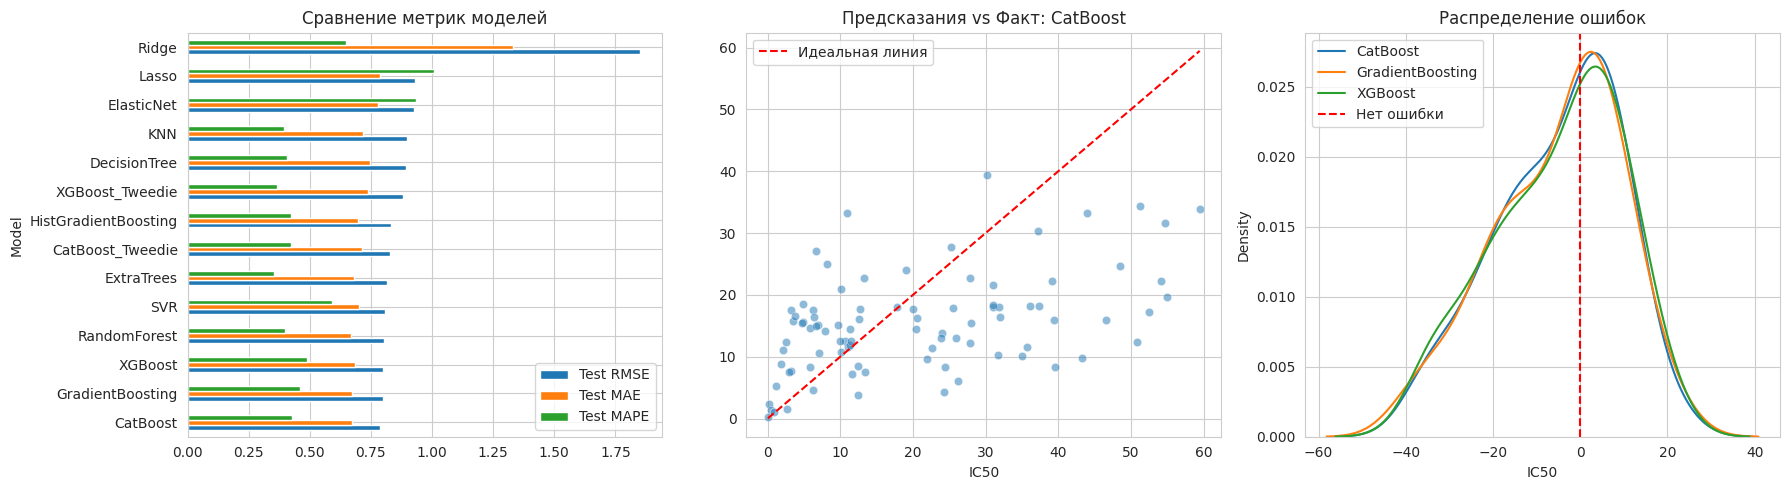

Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_catboost.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_gradientboosting.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_xgboost.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_randomforest.pkl
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_svr.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_metrics.csv


In [32]:
# @title Тест моделей на ручных данных
# инициализация
evaluator_handmade = RegressionModelEvaluator(X1, y1, metod_name=metod_name_1, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_handmade.evaluate_models(verbose=True, metrics_filename=table_1)
results_handmade = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_handmade)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_handmade.save_top_models(n=5, prefix=final_1)

In [33]:
results_handmade.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
CatBoost,handmade,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",0.782022,0.623004,0.789306,0.671818,0.345869,0.348027,1.553494,0.426525,True,<catboost.core.CatBoostRegressor object at 0x7...
GradientBoosting,handmade,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",0.813072,0.638440,0.799025,0.673585,0.329661,0.333041,1.565540,0.461380,True,([DecisionTreeRegressor(criterion='friedman_ms...
XGBoost,handmade,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.783715,0.642153,0.801344,0.684747,0.325763,0.327996,1.607442,0.489221,True,"XGBRegressor(base_score=None, booster=None, ca..."
RandomForest,handmade,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.784828,0.646013,0.803749,0.669786,0.321710,0.327331,1.615659,0.397808,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."
SVR,handmade,"{'svr__C': 1, 'svr__epsilon': 0.5, 'svr__kerne...",0.863408,0.651728,0.807297,0.699559,0.315709,0.317241,1.790866,0.590262,True,"(StandardScaler(), SVR(C=1, epsilon=0.5))"


Подбор параметров Ridge...
выполнено: Test MSE: 1.070
Подбор параметров Lasso...
выполнено: Test MSE: 0.844
Подбор параметров ElasticNet...
выполнено: Test MSE: 0.821
Подбор параметров SVR...
выполнено: Test MSE: 0.790
Подбор параметров KNN...
выполнено: Test MSE: 0.832
Подбор параметров DecisionTree...
выполнено: Test MSE: 1.207
Подбор параметров ExtraTrees...
выполнено: Test MSE: 0.720
Подбор параметров RandomForest...
выполнено: Test MSE: 0.727
Подбор параметров GradientBoosting...
выполнено: Test MSE: 0.777
Подбор параметров HistGradientBoosting...
выполнено: Test MSE: 0.802
Подбор параметров XGBoost...
выполнено: Test MSE: 0.881
Подбор параметров CatBoost...
выполнено: Test MSE: 0.812
Подбор параметров XGBoost_Tweedie...
выполнено: Test MSE: 1.080
Подбор параметров CatBoost_Tweedie...
выполнено: Test MSE: 0.723
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_pca.csv


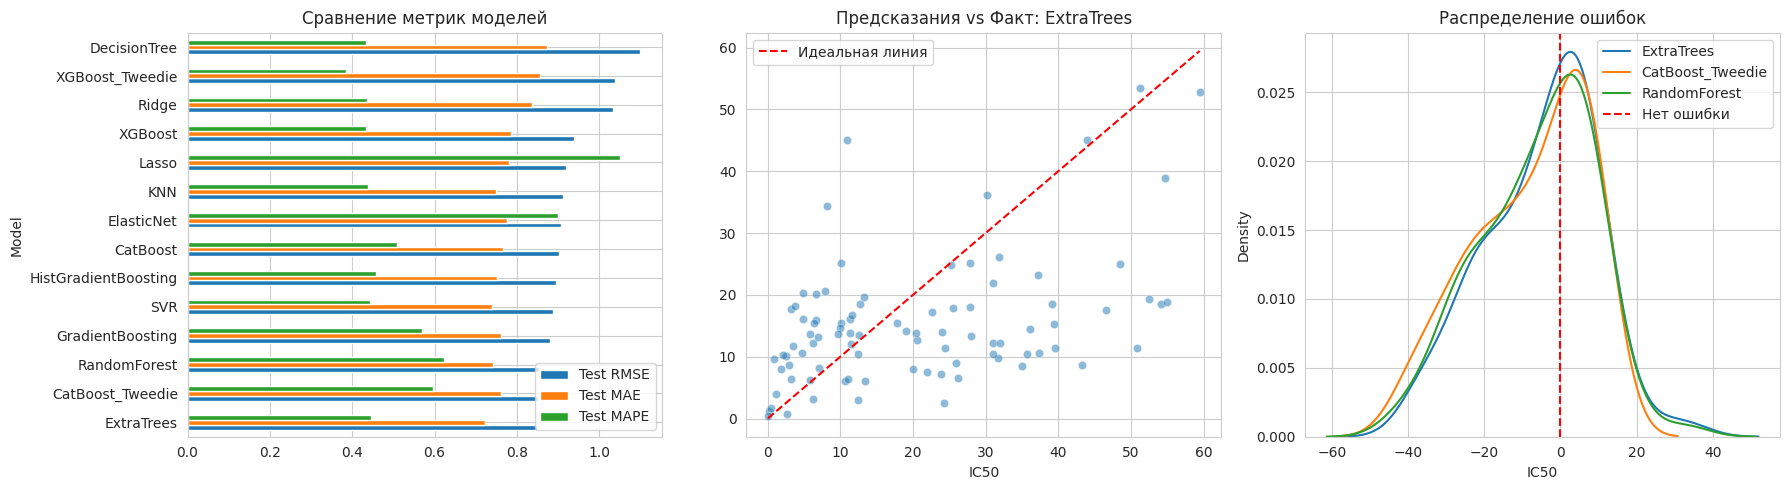

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_extratrees.pkl
Модель CatBoost_Tweedie сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_catboost_tweedie.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_randomforest.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_gradientboosting.pkl
Модель SVR сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_svr.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_pca_metrics.csv


In [34]:
# @title Тест моделей на данных pca
# инициализация
evaluator_pca = RegressionModelEvaluator(X2, y2, metod_name=metod_name_2, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_pca.evaluate_models(verbose=True, metrics_filename=table_2)
results_pca = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_pca)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_pca.save_top_models(n=5, prefix=final_2)

In [35]:
results_pca.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
ExtraTrees,pca,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.847115,0.720495,0.848819,0.723488,0.243507,0.251879,1.988132,0.446755,True,"(ExtraTreeRegressor(min_samples_split=5, rando..."
CatBoost_Tweedie,pca,"{'depth': 3, 'iterations': 200, 'l2_leaf_reg':...",0.962897,0.723474,0.850573,0.761556,0.240379,0.271936,1.648421,0.595798,True,<catboost.core.CatBoostRegressor object at 0x7...
RandomForest,pca,"{'max_depth': None, 'max_features': 0.8, 'min_...",0.891861,0.726969,0.852625,0.743056,0.236709,0.247524,1.817678,0.623399,True,"(DecisionTreeRegressor(max_features=0.8, min_s..."
GradientBoosting,pca,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",0.864626,0.777088,0.881526,0.760862,0.184086,0.199731,1.812645,0.568637,True,([DecisionTreeRegressor(criterion='friedman_ms...
SVR,pca,"{'svr__C': 8, 'svr__epsilon': 0.4, 'svr__kerne...",0.901504,0.790099,0.888875,0.739319,0.170425,0.194791,2.204025,0.444346,True,"(StandardScaler(), SVR(C=8, epsilon=0.4))"


Подбор параметров Ridge...
выполнено: Test MSE: 0.963
Подбор параметров Lasso...
выполнено: Test MSE: 0.958
Подбор параметров ElasticNet...
выполнено: Test MSE: 0.957
Подбор параметров SVR...
выполнено: Test MSE: 0.961
Подбор параметров KNN...
выполнено: Test MSE: 0.784
Подбор параметров DecisionTree...
выполнено: Test MSE: 1.082
Подбор параметров ExtraTrees...
выполнено: Test MSE: 0.787
Подбор параметров RandomForest...
выполнено: Test MSE: 0.794
Подбор параметров GradientBoosting...
выполнено: Test MSE: 0.941
Подбор параметров HistGradientBoosting...
выполнено: Test MSE: 0.929
Подбор параметров XGBoost...
выполнено: Test MSE: 0.944
Подбор параметров CatBoost...
выполнено: Test MSE: 0.793
Подбор параметров XGBoost_Tweedie...
выполнено: Test MSE: 0.961
Подбор параметров CatBoost_Tweedie...
выполнено: Test MSE: 0.820
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_tsne.csv


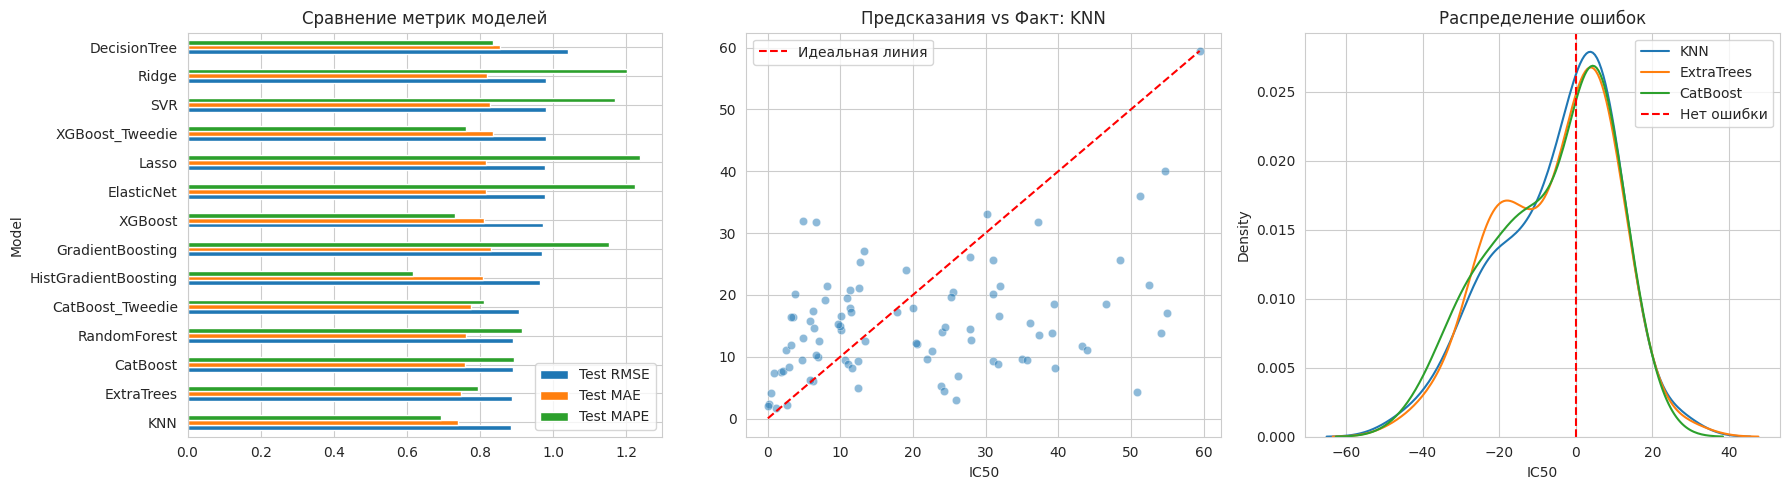

Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_knn.pkl
Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_extratrees.pkl
Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_catboost.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_randomforest.pkl
Модель CatBoost_Tweedie сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_catboost_tweedie.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_tsne_metrics.csv


In [37]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных tSME(3 параметра)
# инициализация
evaluator_tsne = RegressionModelEvaluator(X3, y3, metod_name=metod_name_3, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tsne.evaluate_models(verbose=True, metrics_filename=table_3)
results_tsne = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tsne)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tsne.save_top_models(n=5, prefix=final_3)

In [38]:
results_tsne.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
KNN,tsne,"{'kneighborsregressor__n_neighbors': 8, 'kneig...",1.016334,0.784354,0.885638,0.738812,0.176457,0.179549,2.267396,0.692499,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
ExtraTrees,tsne,"{'max_depth': None, 'min_samples_split': 5, 'n...",0.961554,0.786626,0.886919,0.749121,0.174072,0.176719,2.076794,0.794929,True,"(ExtraTreeRegressor(min_samples_split=5, rando..."
CatBoost,tsne,"{'depth': 7, 'iterations': 100, 'l2_leaf_reg':...",1.007153,0.792557,0.890257,0.758830,0.167845,0.169413,1.883436,0.892531,True,<catboost.core.CatBoostRegressor object at 0x7...
RandomForest,tsne,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.994387,0.794212,0.891186,0.760499,0.166107,0.167029,1.975746,0.915067,True,"(DecisionTreeRegressor(max_depth=20, max_featu..."
CatBoost_Tweedie,tsne,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",1.076028,0.819614,0.905325,0.774466,0.139436,0.164675,2.050700,0.811182,True,<catboost.core.CatBoostRegressor object at 0x7...


Подбор параметров Ridge...
выполнено: Test MSE: 0.942
Подбор параметров Lasso...
выполнено: Test MSE: 0.937
Подбор параметров ElasticNet...
выполнено: Test MSE: 0.938
Подбор параметров SVR...
выполнено: Test MSE: 0.915
Подбор параметров KNN...
выполнено: Test MSE: 0.779
Подбор параметров DecisionTree...
выполнено: Test MSE: 1.102
Подбор параметров ExtraTrees...
выполнено: Test MSE: 0.738
Подбор параметров RandomForest...
выполнено: Test MSE: 0.805
Подбор параметров GradientBoosting...
выполнено: Test MSE: 0.799
Подбор параметров HistGradientBoosting...
выполнено: Test MSE: 0.823
Подбор параметров XGBoost...
выполнено: Test MSE: 0.779
Подбор параметров CatBoost...
выполнено: Test MSE: 0.809
Подбор параметров XGBoost_Tweedie...
выполнено: Test MSE: 0.904
Подбор параметров CatBoost_Tweedie...
выполнено: Test MSE: 0.806
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_umap.csv


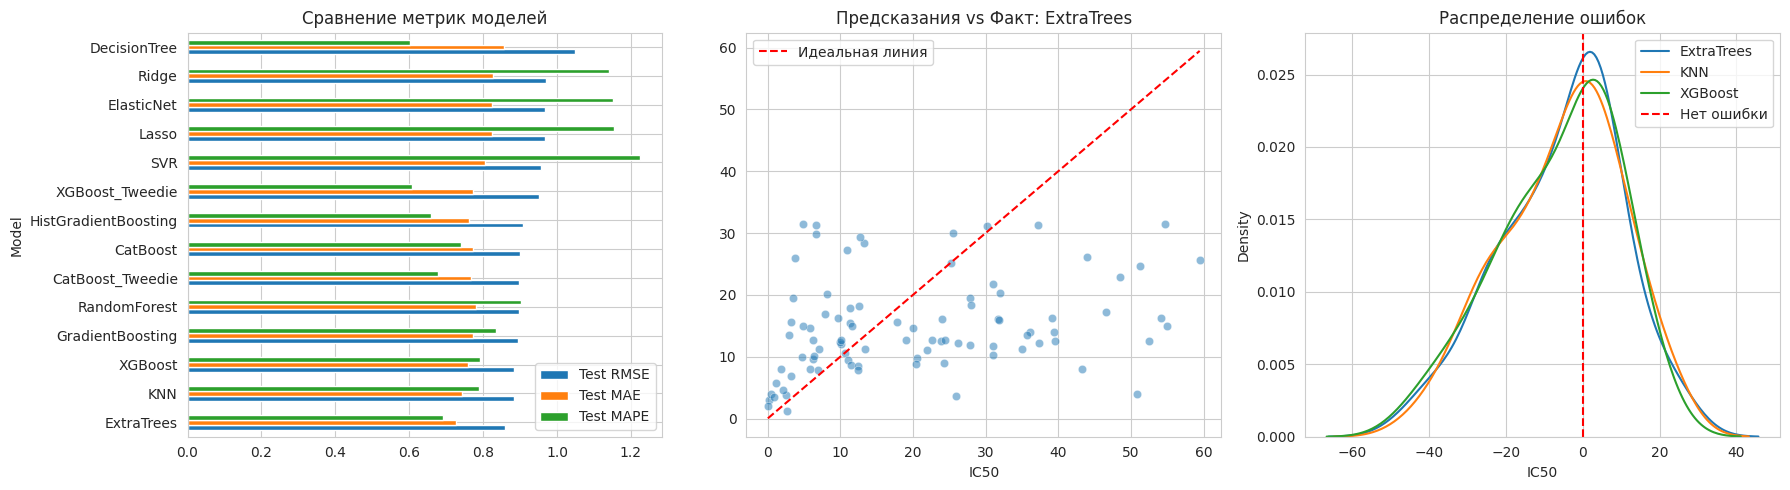

Модель ExtraTrees сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_extratrees.pkl
Модель KNN сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_knn.pkl
Модель XGBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_xgboost.pkl
Модель GradientBoosting сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_gradientboosting.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_randomforest.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_umap_metrics.csv


In [39]:
# @title Тест моделей на ОЧИЩЕННЫХ от выбросов даннык, масштабированных UMAP(3 параметра)
# инициализация
evaluator_umap = RegressionModelEvaluator(X4, y4, metod_name=metod_name_4, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_umap.evaluate_models(verbose=True, metrics_filename=table_4)
results_umap = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_umap)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_umap.save_top_models(n=5, prefix=final_4)

In [40]:
results_umap.head(5)

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
ExtraTrees,umap,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.993911,0.738444,0.859327,0.726341,0.224661,0.228204,2.335575,0.690836,True,"(ExtraTreeRegressor(max_depth=10, min_samples_..."
KNN,umap,"{'kneighborsregressor__n_neighbors': 15, 'knei...",0.965819,0.778843,0.882521,0.742315,0.182244,0.186146,2.093668,0.788805,True,"(StandardScaler(), KNeighborsRegressor(n_neigh..."
XGBoost,umap,"{'colsample_bytree': 1.0, 'learning_rate': 0.0...",0.992087,0.779223,0.882736,0.759757,0.181845,0.186510,2.414113,0.791882,True,"XGBRegressor(base_score=None, booster=None, ca..."
GradientBoosting,umap,"{'learning_rate': 0.05, 'max_depth': 3, 'min_s...",1.059295,0.799485,0.894139,0.771536,0.160571,0.162799,2.335595,0.835087,True,([DecisionTreeRegressor(criterion='friedman_ms...
RandomForest,umap,"{'max_depth': 5, 'max_features': 'sqrt', 'min_...",0.987309,0.804651,0.897023,0.781638,0.155146,0.157684,2.197963,0.903509,True,"(DecisionTreeRegressor(max_depth=5, max_featur..."


# СВОД И ВЫВОДЫ


In [41]:
# @title Датасет с результатами всех моделей на валидационной выборке
# Список файлов с результатами
result_files = [table_1, table_2, table_3, table_4]

# Создаем список для хранения датафреймов
dfs = []

# Читаем каждый файл и добавляем в список
for file in result_files:
    # Полный путь к файлу
    file_path = os.path.join(data_dir, file)

    # Читаем CSV
    df = pd.read_csv(file_path)

    # Добавляем в список
    dfs.append(df)

# Объединяем все датафреймы
combined_results = pd.concat(dfs, ignore_index=True)

# Сохраняем объединенный результат
combined_results.to_csv(os.path.join(data_dir, csv_file_final), index=False)

# Выводим первые строки для проверки
combined_results_for_view=combined_results.drop(['Best Parameters', 'Model Object'], axis = 1)
combined_results_for_view = combined_results_for_view.sort_values(by='Test MSE', ascending=True)
combined_results_for_view.head(5)

,Model,Metod,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target
0,CatBoost,handmade,0.782022,0.623004,0.789306,0.671818,0.345869,0.348027,1.553494,0.426525,True
1,GradientBoosting,handmade,0.813072,0.638440,0.799025,0.673585,0.329661,0.333041,1.565540,0.461380,True
2,XGBoost,handmade,0.783715,0.642153,0.801344,0.684747,0.325763,0.327996,1.607442,0.489221,True
3,RandomForest,handmade,0.784828,0.646013,0.803749,0.669786,0.321710,0.327331,1.615659,0.397808,True
4,SVR,handmade,0.863408,0.651728,0.807297,0.699559,0.315709,0.317241,1.790866,0.590262,True


In [59]:
# @title вытащим гиперпарамаетры выбранной модели
filtered_row = combined_results[(combined_results['Model'] == "CatBoost") & (combined_results['Metod'] == "handmade")]
value = filtered_row.iloc[0]['Best Parameters']
value

"{'depth': 7, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}"

Подбор параметров RandomForest...
выполнено: Test MSE: 0.646
Подбор параметров CatBoost...
выполнено: Test MSE: 0.623
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_handmade.csv


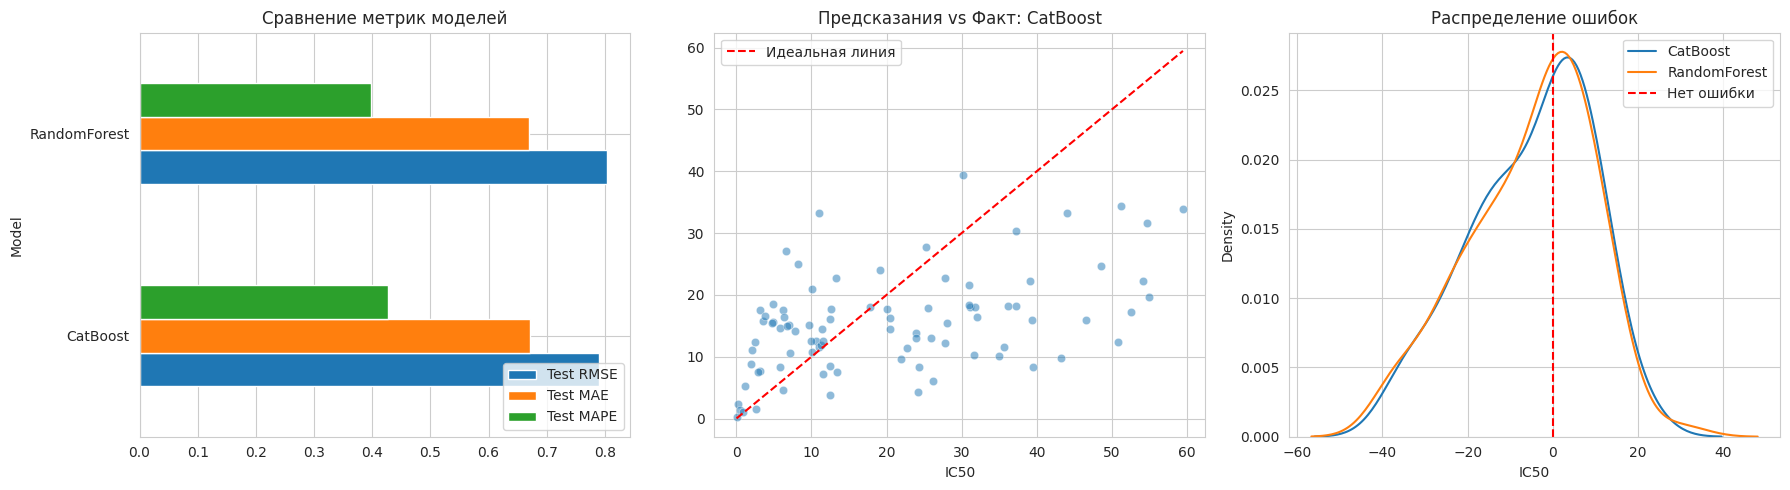

Модель CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_catboost.pkl
Модель RandomForest сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_randomforest.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_metrics.csv


In [71]:
# @title ТЮНИНГ RandomForest и CatBoost
random_state=42
from sklearn.ensemble import VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# подготовка данных
metod_name_tuning = 'handmade_tuning'
base_name_tuning = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_tuning = f"table_{base_name_tuning}.csv"
final_tuning = f"{base_name_tuning}_"

# модели и гиперпараметры
models_tuning = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=random_state),
        'params': {
            'n_estimators': [150, 175, 200, 225, 250],
            'max_depth': [8, 10, 12],
            'min_samples_split': [2],
            'max_features': ['sqrt']
        }
    },
    'CatBoost': {
        'model': CatBoostRegressor(random_state=random_state, silent=True),
        'params': {
            'iterations': [150, 175, 200, 225, 250],
            'learning_rate': [0.03, 0.05, 0.07],
            'depth': [5, 7, 9],
            'l2_leaf_reg': [3, 5, 7]
        }
    }
}

# инициализация
evaluator_tuning = RegressionModelEvaluator(X1, y1, models_config=models_tuning, metod_name=metod_name_tuning, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tuning.evaluate_models(verbose=True, metrics_filename=table_tuning)
results_tuning = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tuning)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tuning.save_top_models(n=5, prefix=final_tuning)

In [55]:
results_tuning

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
CatBoost,handmade_tuning,"{'depth': 7, 'iterations': 200, 'l2_leaf_reg':...",0.782022,0.623004,0.789306,0.671818,0.345869,0.348027,1.553494,0.426525,True,<catboost.core.CatBoostRegressor object at 0x7...
RandomForest,handmade_tuning,"{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.784828,0.646013,0.803749,0.669786,0.321710,0.327331,1.615659,0.397808,True,"(DecisionTreeRegressor(max_depth=10, max_featu..."


In [60]:
print("Best params:", results_tuning.loc['RandomForest', 'Best Parameters'])

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}


Подбор параметров Voting_RandomForest_CatBoost...
выполнено: Test MSE: 0.630
Подбор параметров Stacking_RandomForest_CatBoost...
выполнено: Test MSE: 0.799
Метрики всех моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/table_IC50_regres_handmade.csv


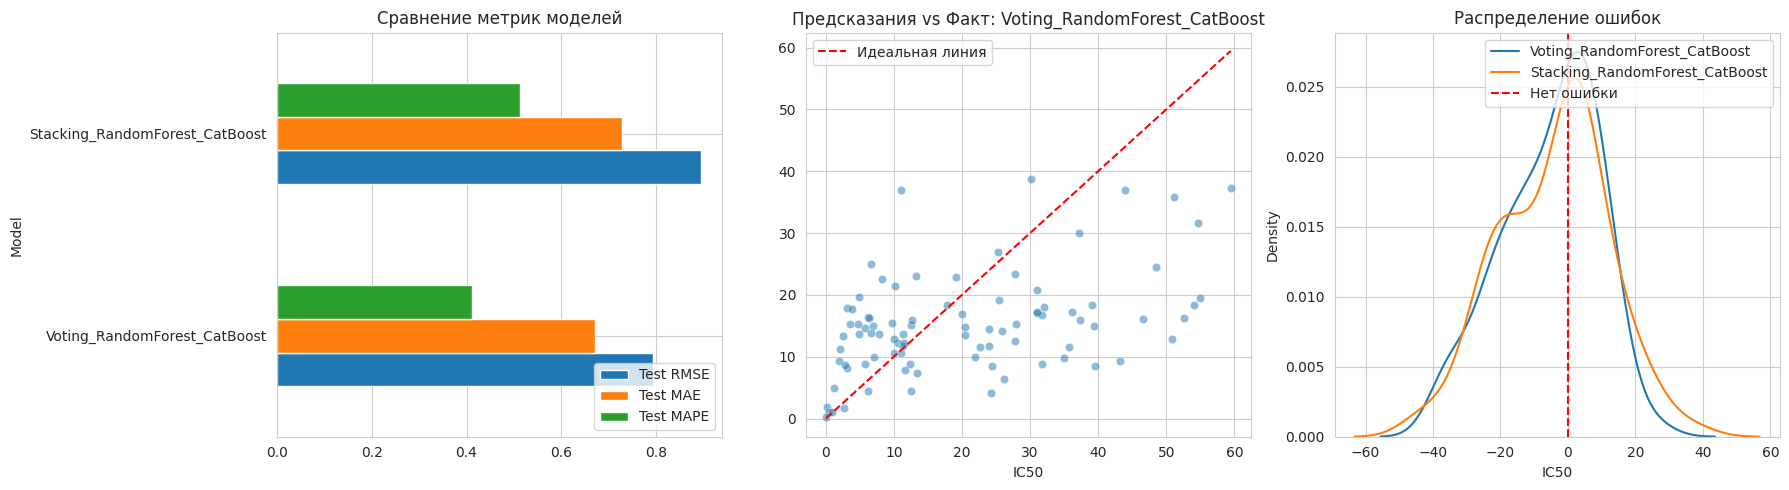

Модель Voting_RandomForest_CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_voting_randomforest_catboost.pkl
Модель Stacking_RandomForest_CatBoost сохранена в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_stacking_randomforest_catboost.pkl
Метрики топ-5 моделей сохранены в /content/drive/My Drive/Colab Notebooks/data/Kurs_classik_ML/IC50_regres_handmade_metrics.csv


In [69]:
# @title оркестрация RandomForest и CatBoost - Voting и Stacking
random_state=42
from sklearn.ensemble import VotingRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor

# подготовка данных
metod_name_tuning = 'handmade_tuning'
base_name_tuning = f"{base_parameter}_{analyse_name}_{metod_name_1}"
table_tuning = f"table_{base_name_tuning}.csv"
final_tuning = f"{base_name_tuning}_"

# модели и гиперпараметры
models_tuning = {
        'Voting_RandomForest_CatBoost': {
        'model': VotingRegressor(
            estimators=[
                ('catboost', CatBoostRegressor(random_state=random_state, silent=True)),
                ('random_forest', RandomForestRegressor(random_state=random_state))
            ]
        ),
        'params': {
            'catboost__iterations': [200],
            'catboost__learning_rate': [0.05],
            'catboost__depth': [7],
            'catboost__l2_leaf_reg': [5],
            'random_forest__n_estimators': [200],
            'random_forest__max_depth': [10],
            'random_forest__min_samples_split': [2],
            'random_forest__max_features': ['sqrt'],
        }
    },
    'Stacking_RandomForest_CatBoost': {
        'model': StackingRegressor(
            estimators=[
                ('catboost', CatBoostRegressor(random_state=random_state, silent=True)),
                ('random_forest', RandomForestRegressor(random_state=random_state))
            ],
            final_estimator=RandomForestRegressor(random_state=random_state)
        ),
        'params': {
            'catboost__iterations': [200],
            'catboost__learning_rate': [0.05],
            'catboost__depth': [7],
            'catboost__l2_leaf_reg': [5],
            'random_forest__n_estimators': [200],
            'random_forest__max_depth': [10],
            'random_forest__min_samples_split': [2],
            'random_forest__max_features': ['sqrt'],
        }
    }
}

# инициализация
evaluator_tuning = RegressionModelEvaluator(X1, y1, models_config=models_tuning, metod_name=metod_name_tuning, log_target=True) # ПОМЕНЯТЬ ТУТ!
results = evaluator_tuning.evaluate_models(verbose=True, metrics_filename=table_tuning)
results_tuning = results.copy()

# Диаграмки
visualizer = RegressionResultsVisualizer(evaluator_tuning)
visualizer.visualize_all()

# Сохранение топ-3 моделей
saved_files = evaluator_tuning.save_top_models(n=5, prefix=final_tuning)

In [70]:
results_tuning

,Metod,Best Parameters,CV MSE,Test MSE,Test RMSE,Test MAE,Test R2,Test Explained Variance,Test Max Error,Test MAPE,Log Target,Model Object
Model,,,,,,,,,,,,
Voting_RandomForest_CatBoost,handmade_tuning,"{'catboost__depth': 7, 'catboost__iterations':...",0.779032,0.629861,0.793638,0.670263,0.338669,0.342355,1.584576,0.411950,True,"VotingRegressor(estimators=[('catboost',\n ..."
Stacking_RandomForest_CatBoost,handmade_tuning,"{'catboost__depth': 7, 'catboost__iterations':...",1.041132,0.798636,0.893664,0.727028,0.161462,0.166037,1.995222,0.513173,True,"StackingRegressor(estimators=[('catboost',\n ..."


In [72]:
print("Best params:", results_tuning.loc['RandomForest', 'Best Parameters'])

Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
